In [1]:
import pandas as pd
import json
from main import load_base_model, load_yml
from models.dino import utils
from models.dino import vision_transformer as vits
from models.classification import linear
from pathlib import Path
from _types import Config
%load_ext autoreload
%autoreload 1

In [2]:
ROOT = Path("/home/sepal-user/")
config_file = ROOT /"sig-ssl4eo/linear-dino-0.yml"
config = Config(**load_yml(config_file))
print(config) 

Config(imgs_training='/home/sepal-user/data_ssl4eo/data_ssl4eo/training/imgs', labels_training='/home/sepal-user/sig-ssl4eo/fao_models/data/match_training_sample.csv', imgs_testing='/home/sepal-user/data_ssl4eo/data_ssl4eo/testing/imgs', labels_testing='/home/sepal-user/sig-ssl4eo/fao_models/data/match_testing_sample.csv', arch='vit_small', model_root='/home/sepal-user/sig-ssl4eo/B13_vits16_dino_0099_ckpt.pth', avgpool_patchtokens=False, patch_size=16, n_last_blocks=4, lr=0.001, batch_size=32, checkpoints_dir='linear-dino-0', resume=True, epochs=5, num_workers=10, seed=42, random_subset_frac=0.01, checkpoint_key='teacher')


In [ ]:
from datasets.ssl4eo_dataset import SSL4EO, random_subset
from torch.utils.data import DataLoader
_data_train = SSL4EO(
    root=config.imgs_training, 
    mode="s2c", 
    label=config.labels_training, 
    normalize=False
)
_data_test = SSL4EO(
    root=config.imgs_testing, 
    mode="s2c", 
    label=config.labels_testing, 
    normalize=False
)
_data_train = random_subset(_data_train, config.random_subset_frac, config.seed)
_data_test = random_subset(_data_train, config.random_subset_frac, config.seed)

val_loader = DataLoader(
    _data_test, batch_size=2, shuffle=False, drop_last=True
)

In [ ]:
import torch
image, target = _data_test[8]
image = torch.unsqueeze(torch.tensor(image),0).type(torch.float32)
target = torch.unsqueeze(torch.tensor(target),0).type(torch.float32)

In [ ]:

model, embed_dim = load_base_model(
    pretrained=config.model_root,
    checkpoint_key=config.checkpoint_key,
    arch=config.arch,
    patch_size=config.patch_size,
    n_last_blocks=config.n_last_blocks,
    avgpool_patchtokens=config.avgpool_patchtokens,
)
linear_classifier = linear.LinearClassifier(embed_dim, num_labels=2)

In [ ]:
linear_classifier.eval()
with torch.no_grad():
    intermediate_output = model.get_intermediate_layers(image, config.n_last_blocks)
    output = torch.cat([x[:, 0] for x in intermediate_output], dim=-1)

output = linear_classifier(output)

In [ ]:
from sklearn.metrics import average_precision_score
score = torch.sigmoid(output).detach().cpu()
acc1 = average_precision_score(target, score, average="micro") * 100.0
score, target, acc1

In [ ]:
tscore = [[0.6,0.2],[0.6,0.2]]
ttarget = [[0,1],   [0,1]]
tacc1 = average_precision_score(ttarget, tscore, average="micro") * 100.0
tscore, ttarget, tacc1

In [ ]:
import torch
from torch import nn
loss = nn.CrossEntropyLoss()
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
print(input, target)

In [ ]:
from sklearn.metrics import average_precision_score
y_true = [1,1,0,0]
y_scores = [0.2,0.3,0.0045,0.0072]  # Predicted probabilities of being in class 1
ap_score = average_precision_score(y_true, y_scores)
print("Average Precision Score:", ap_score)

In [3]:
# unpack log
log_data = []
log_path = ROOT / "sig-ssl4eo/linear-dino-2/log.txt"
with open(log_path) as file:
    while line := file.readline():
        line = json.loads(line.rstrip())
        print(line)
        log_data.append(line)
df = pd.DataFrame(log_data)

{'train_lr': 0.000999999999999928, 'train_loss': 0.40117577586326864, 'epoch': 0, 'test_loss': 0.36773691701588873, 'test_average_precision_score': 80.74726271376005, 'test_binary_f1_score': 0.6518745794892311}
{'train_lr': 0.000989073800366865, 'train_loss': 0.37946256785437427, 'epoch': 1, 'test_loss': 0.406384619913227, 'test_average_precision_score': 81.93588536643126, 'test_binary_f1_score': 0.7085780034677016}
{'train_lr': 0.0009567727288213237, 'train_loss': 0.36937347564419837, 'epoch': 2, 'test_loss': 0.36182669958443664, 'test_average_precision_score': 82.25167575810114, 'test_binary_f1_score': 0.7108216459731118}
{'train_lr': 0.0009045084971874302, 'train_loss': 0.3616601009909211, 'epoch': 3, 'test_loss': 0.3516061860773203, 'test_average_precision_score': 82.14429128303235, 'test_binary_f1_score': 0.6962663501822691}
{'train_lr': 0.0008345653031794302, 'train_loss': 0.3576329000096995, 'epoch': 4, 'test_loss': 0.3400549090934171, 'test_average_precision_score': 83.20292641

In [23]:
import matplotlib.pyplot as plt

def plot_training_curves(df, keys_to_plot:list):
    line_styles = ['-', '--', '-.', ':']  # List of line styles
    colors = ['blue', 'green', 'red', 'purple']  # List of colors

    # Iterate over each dictionary and key
    
    for j, key_to_plot in enumerate(keys_to_plot):
        # Get the values for the specified key
        values = df[key_to_plot]

        # Create the line graph with different line styles and colors
        plt.plot(values, linestyle=line_styles[j % len(line_styles)], color=colors[j % len(colors)])

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Curves - {}'.format(', '.join(keys_to_plot)))
    
    # Create a list of legend items
    legend_items = []

    for key_to_plot in keys_to_plot:
        legend_items.append(key_to_plot)
    
    plt.legend(legend_items)  # Display legend items
    plt.show()


Index(['train_lr', 'train_loss', 'epoch', 'test_loss',
       'test_average_precision_score', 'test_binary_f1_score'],
      dtype='object')


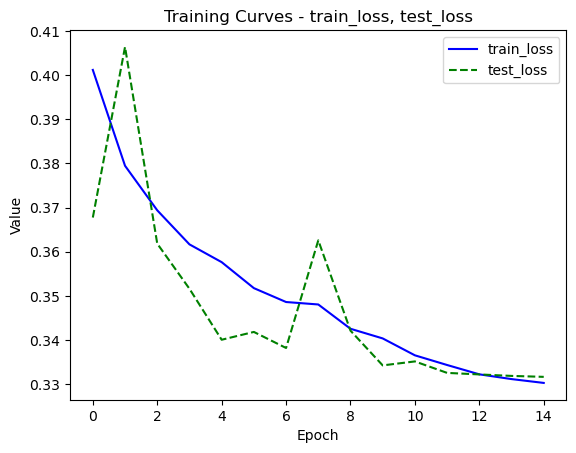

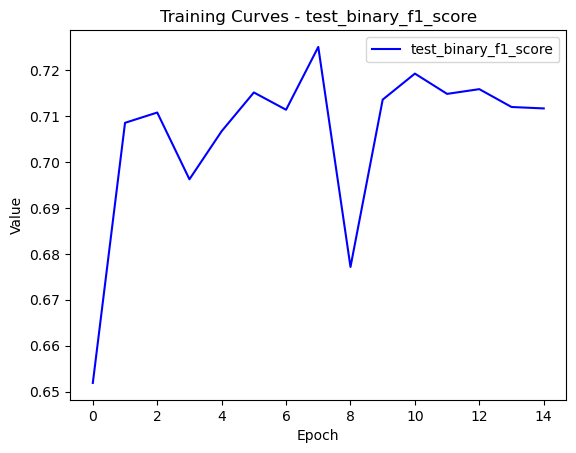

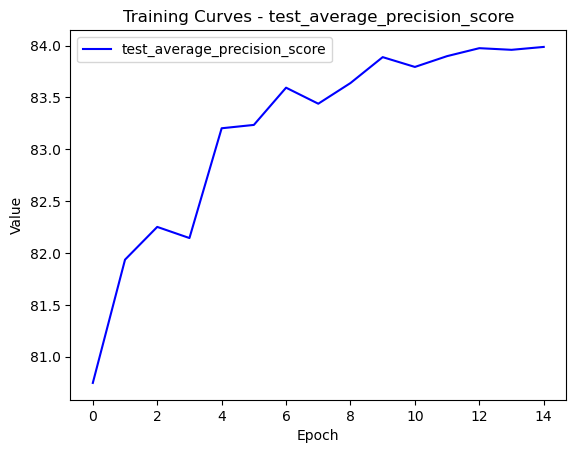

In [25]:
print(df.columns)
plot_training_curves(df, ["train_loss","test_loss"])
plot_training_curves(df, ["test_binary_f1_score"])
plot_training_curves(df, ["test_average_precision_score"])

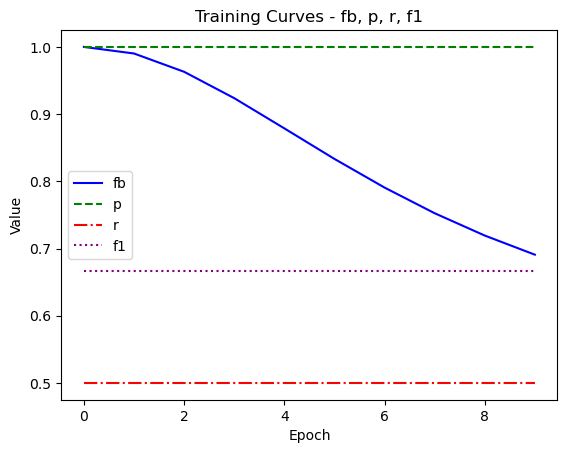

In [39]:
from sklearn import metrics
y_pred = [0, 1, 0, 0]
y_true = [0, 1, 0, 1]

data = []
for i in range(0,100, 10):
    b = i/100
    fb_score = metrics.fbeta_score(y_true, y_pred, beta=b)
    p_score = metrics.precision_score(y_true, y_pred)
    r_score = metrics.recall_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    step = i
    data.append({'step':step,'p':p_score,'fb':fb_score,'r':r_score, 'f1':f1_score})

df = pd.DataFrame(data)
df.columns
plot_training_curves(df,['fb','p','r','f1'])